# Initial Investigations: Neural Networks with Uncertainty

This notebook explores building neural networks that provide uncertainty estimates and evaluates metrics that leverage these uncertainty measures.

## Importing all the libraries

In [392]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.layers import Dense, Dropout
from keras.datasets.mnist import load_data
from keras.utils import to_categorical
from math import log


## Loading the dataset

In [393]:
(x_train, y_train), (x_test, y_test) = load_data("mnist.npz")
# Normalize the data
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Flatten the data (from 28x28 to 784)
flattened_input_shape = x_train[0].shape[0] * x_train[0].shape[1]
x_train = x_train.reshape((x_train.shape[0], flattened_input_shape))
x_test = x_test.reshape((x_test.shape[0], flattened_input_shape))
# Convert labels to one-hot encoding (needed for categorical crossentropy)
n_classes = len(np.unique(y_train))
y_train = to_categorical(y_train, n_classes)
y_test = to_categorical(y_test, n_classes)

## Building the model

In [394]:
model = keras.Sequential([
    Dense(units=16, input_shape=(flattened_input_shape,), activation="relu"), # hidden layer
    Dropout(0.5), # dropout to previous layer
    Dense(units=16, activation="relu"), # hidden layer
    Dense(units=n_classes, activation="softmax"), # output layer
])

## Compiling the model

In [395]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

## Training the model

In [396]:
history = model.fit(x_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
750/750 [==============================] - 1s 673us/step - loss: 1.2549 - accuracy: 0.5544 - val_loss: 0.5052 - val_accuracy: 0.8876
Epoch 2/10
750/750 [==============================] - 0s 567us/step - loss: 0.8951 - accuracy: 0.6882 - val_loss: 0.4108 - val_accuracy: 0.9038
Epoch 3/10
750/750 [==============================] - 0s 578us/step - loss: 0.8378 - accuracy: 0.7104 - val_loss: 0.3803 - val_accuracy: 0.9048
Epoch 4/10
750/750 [==============================] - 0s 574us/step - loss: 0.8179 - accuracy: 0.7202 - val_loss: 0.3767 - val_accuracy: 0.9060
Epoch 5/10
750/750 [==============================] - 0s 589us/step - loss: 0.7972 - accuracy: 0.7287 - val_loss: 0.3494 - val_accuracy: 0.9105
Epoch 6/10
750/750 [==============================] - 0s 579us/step - loss: 0.7729 - accuracy: 0.7408 - val_loss: 0.3440 - val_accuracy: 0.9111
Epoch 7/10
750/750 [==============================] - 0s 591us/step - loss: 0.7532 - accuracy: 0.7476 - val_loss: 0.3359 - val_accuracy:

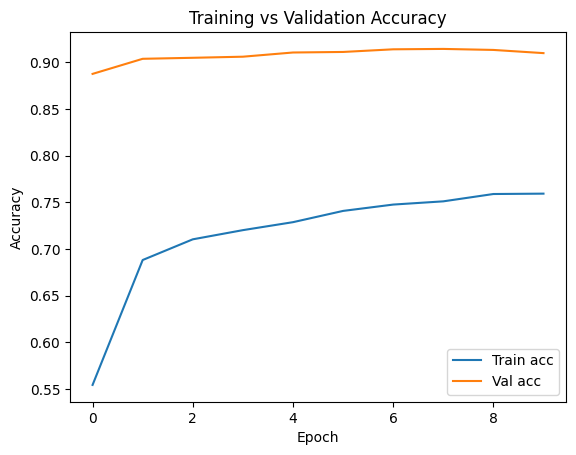

In [397]:
# Plot trainininng vs validation accuracy
plt.plot(history.history['accuracy'], label='Train acc')
plt.plot(history.history['val_accuracy'], label='Val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

## Computing uncecrtainty as entropy on some examples

In [398]:
# Compute the normalized entropy as uncerainty measure given a list of probabilities
def compute_entropy(prediction):
    entropy = 0
    for prob in prediction:
        if prob > 0:
            entropy += -prob*log(prob)
    entropy = entropy / log(len(prediction)) # Normalize entropy to get uncertainty
    return entropy

In [399]:
# Predict and compute the entropy (i.e., the uncertainty) for the given input
def predict_with_entropy(x):
    x = np.expand_dims(x, axis=0)  # adds batch dimension in position 0
    prediction = model.predict(x)[0] # x has to have batch dimension
    output = np.argmax(prediction)
    uncertainty = compute_entropy(prediction)
    return output, uncertainty

In [400]:
# Compute the entropy (i.e., the uncertainty) for the first 4 images in the dataset
print("-- Entropy --")
for i in range(4):
    output, uncertainty = predict_with_entropy(x_test[i])
    actual = np.argmax(y_test[i])
    print(f"Example {i}:")
    print(f"\tActual label: {actual} - Prediction: {output}")
    print(f"\tUncertainty: {uncertainty*100:.2f}%")

-- Entropy --
Example 0:
	Actual label: 7 - Prediction: 7
	Uncertainty: 0.78%
Example 1:
	Actual label: 2 - Prediction: 2
	Uncertainty: 0.48%
Example 2:
	Actual label: 1 - Prediction: 1
	Uncertainty: 9.96%
Example 3:
	Actual label: 0 - Prediction: 0
	Uncertainty: 1.54%


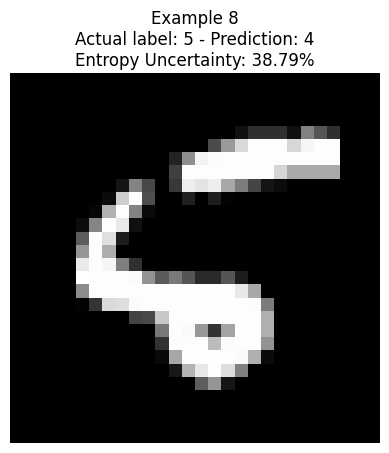

In [401]:
# Compute entropy for image 8 in the dataset, that shows to be complex to be predicted
output, uncertainty = predict_with_entropy(x_test[8])
actual = np.argmax(y_test[8])
# Plot the image
plt.imshow(x_test[8].reshape(28, 28), cmap='gray')
plt.title(f"Example 8\nActual label: {actual} - Prediction: {output}\nEntropy Uncertainty: {uncertainty*100:.2f}%")
plt.axis('off')
plt.show()

## Computing uncertainty using dropout on some examples

In [402]:
# Predict using Monte Carlo Dropout, also compute uncertainty as standard deviation 
def mc_dropout_prediction(model, x):
    x = np.expand_dims(x, axis=0)  # adds batch dimension in position 0
    prediction = np.array([model(x, training=True)[0] for _ in range(10)]) # run ten times enabling dropout
    mean = np.mean(prediction, axis=0)
    output = np.argmax(mean)
    # Take the max probability for each run (usually associated with the same class)
    # and compute the standard deviation as uncerainty measure
    max_probs = np.max(prediction, axis=1)
    uncertainty = np.std(max_probs)
    return mean, uncertainty

In [403]:
# Compute the uncertainty (with MC Dropout) for the first 4 images in the dataset
print("-- MC Dropout --")
for i in range(4):
    mean, uncertainty = mc_dropout_prediction(model, x=x_test[i])
    actual = np.argmax(y_test[i])
    output = np.argmax(mean)
    print(f"Example {i}:")
    print(f"\tActual label: {actual} - Prediction: {output}")
    print(f"\tUncertainty: {uncertainty*100:.2f}%")

-- MC Dropout --
Example 0:
	Actual label: 7 - Prediction: 7
	Uncertainty: 3.60%
Example 1:
	Actual label: 2 - Prediction: 2
	Uncertainty: 21.63%
Example 2:
	Actual label: 1 - Prediction: 1
	Uncertainty: 23.80%
Example 3:
	Actual label: 0 - Prediction: 0
	Uncertainty: 23.75%


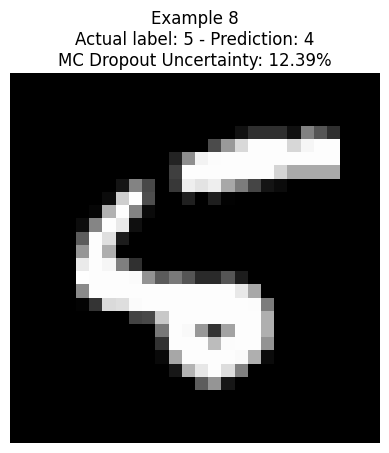

In [404]:
# Compute the uncertainty (with MC Dropout) for image 8 in the dataset, that shows to be complex to predict
mean, uncertainty = mc_dropout_prediction(model, x_test[8])
actual = np.argmax(y_test[8])
output = np.argmax(mean)
# Plot the image
plt.imshow(x_test[8].reshape(28, 28), cmap='gray')
plt.title(f"Example 8\nActual label: {actual} - Prediction: {output}\nMC Dropout Uncertainty: {uncertainty*100:.2f}%")
plt.axis('off')
plt.show()

## Computing proposed accuracy metrics on test dataset

In [405]:
# Compute the three accuracies given the predicted labels, the uncertainties, the correct labeks, and the threshold
def compute_accuracies(predictions, uncertainty, correct_labels, threshold):
    is_label_ok = [1 if np.argmax(pred) == np.argmax(actual) else 0 for pred, actual in zip(predictions, correct_labels)]
    num_was, num_bomb, den_was = 0, 0, 0
    for i in range(len(is_label_ok)):
        num_bomb += is_label_ok[i] * (1-uncertainty[i]) + (1-is_label_ok[i]) * uncertainty[i]
        if uncertainty[i] < threshold:
            num_was += is_label_ok[i]
            den_was += 1

    acc_trad = sum(is_label_ok)/len(is_label_ok)
    acc_bomb = num_bomb/len(is_label_ok)
    if den_was > 0: 
        acc_was = num_was/den_was

    print(f"Traditional accuracy:\t{acc_trad*100:.2f}%")
    print(f"Bombarda accuracy:\t{acc_bomb*100:.2f}%")
    if den_was > 0: 
        print(f"Wasim accuracy:\t\t{acc_was*100:.2f}%")
    else:
        print(f"Wasim accuracy:\t\tundefined")

In [406]:
threshold = 0.3 # output labeled as unknown if uncertainty is greater than 30%

# Predict deterministically using the model and compute uncertainty using entropy
predictions = model.predict(x_test)
uncertainty = [compute_entropy(x) for x in predictions]
print(f"With entropy")
compute_accuracies(predictions, uncertainty, y_test, threshold)

# Predict non deterministically using MC Dropout, that also gives the uncetainty
mc_dropout_results  = [mc_dropout_prediction(model, x) for x in x_test]
predictions = [r[0] for r in mc_dropout_results ]
uncertainty = [r[1] for r in mc_dropout_results ]
print(f"With MC Dropout")
compute_accuracies(predictions, uncertainty, y_test, threshold)

With entropy
Traditional accuracy:	91.08%
Bombarda accuracy:	80.28%
Wasim accuracy:		98.37%
With MC Dropout
Traditional accuracy:	91.15%
Bombarda accuracy:	75.84%
Wasim accuracy:		91.08%
